In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch

from dotenv import load_dotenv, find_dotenv
from pathlib import Path

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
project_dir = Path(dotenv_path).parent

# load up the entries as environment variables
load_dotenv(dotenv_path)

True

# EffNet test

Following mostly https://pytorch.org/hub/nvidia_deeplearningexamples_efficientnet/

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [4]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

efficientnet.eval().to(device)

Using cache found in /home/ctc_das/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/ctc_das/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/ctc_das/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
Using cache found in /home/ctc_das/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [61]:
uris = ['http://images.cocodataset.org/test-stuff2017/000000024309.jpg',]

batch = torch.cat(
    [utils.prepare_input_from_uri(uri) for uri in uris]
).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


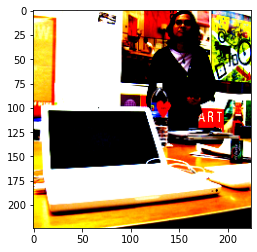

In [34]:
plt.imshow(batch[0].permute(1, 2, 0).cpu())
plt.show()

In [17]:
with torch.no_grad():
    output = efficientnet(batch)
    softm = torch.nn.functional.softmax(output, dim=1)
    
results = utils.pick_n_best(predictions=softm, n=5)
results

sample 0: [('laptop, laptop computer', '49.9%'), ('notebook, notebook computer', '36.2%'), ('desk', '3.7%'), ('mouse, computer mouse', '0.5%'), ('space bar', '0.5%')]


[[('laptop, laptop computer', '49.9%'),
  ('notebook, notebook computer', '36.2%'),
  ('desk', '3.7%'),
  ('mouse, computer mouse', '0.5%'),
  ('space bar', '0.5%')]]

In [75]:
with h5py.File(str(project_dir/'data/interim/renders.hdf5'), "r") as h:
    i = np.random.choice(np.arange(h['renders'].shape[0]))
    j = np.random.choice(np.arange(h['renders'].shape[1]))
    
    sample = h['renders'][i,j]

batch = torch.from_numpy(sample).unsqueeze(0).to(device)
batch = batch.type(torch.cuda.FloatTensor)  # so it agrees with weights dtype
batch.shape

torch.Size([1, 2, 512, 512])

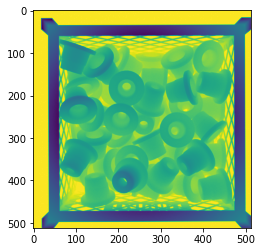

In [76]:
plt.imshow(batch[0,0].cpu())
plt.show()

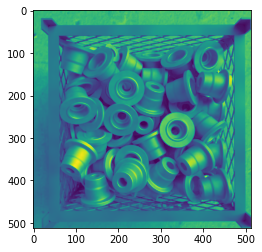

In [77]:
plt.imshow(batch[0,1].cpu())
plt.show()

In [80]:
# our images are 2-channel
efficientnet.stem.conv.in_channels = 2
efficientnet.stem.conv.weight.data = efficientnet.stem.conv.weight[:,:2,:,:]

with torch.no_grad():
    output = efficientnet(batch)
    softm = torch.nn.functional.softmax(output, dim=1)

results = utils.pick_n_best(predictions=softm, n=5)
results

sample 0: [('amphibian, amphibious vehicle', '100.0%'), ('tow truck, tow car, wrecker', '0.0%'), ('tench, Tinca tinca', '0.0%'), ('mitten', '0.0%'), ('mixing bowl', '0.0%')]


[[('amphibian, amphibious vehicle', '100.0%'),
  ('tow truck, tow car, wrecker', '0.0%'),
  ('tench, Tinca tinca', '0.0%'),
  ('mitten', '0.0%'),
  ('mixing bowl', '0.0%')]]